In [1]:
!pip install matplotlib
!pip freeze > requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Ingredient Normalization (Data-Driven, PMI-Based)
This notebook implements a **fully data-driven pipeline** for large-scale ingredient normalization.

### 🔧 **Pipeline Summary**
| Stage | Component | Purpose | Output |
|--------|------------|----------|---------|
| **1** | Config & Setup | Define file paths, thresholds, constants | Paths + Params |
| **2** | **StatsNormalizer** | Build a PMI-based vocabulary of canonical ingredient collocations (uni/bi/tri-grams) | `ingredient_vocab_stats.json` |
| **3** | **Spell/Fuzzy Mapping (Threaded)** | Fast correction of raw ingredient variants using spelling and fuzzy matching | `ner_spell_map.jsonl` |
| **4** | **Cosine Similarity Deduplication** | Identify semantically similar ingredient terms using sentence embeddings (MiniLM) | `cosine_dedupe_map.jsonl` |
| **5** | **Apply Dedup Map** | Replace duplicates in Parquet and write deduped file | `recipes_data_clean_spell_dedup.parquet` |
| **6** | **Summary** | Print stats, vocab size, and output summary | Console output |

### 📦 **Outputs Generated**
- `recipes_data_clean.parquet` — PMI-cleaned dataset
- `recipes_data_clean_spell.parquet` — cleaned + spell-mapped dataset
- `recipes_data_clean_spell_dedup.parquet` — final cosine-deduped dataset
- `ingredient_vocab_stats.json` — canonical vocabulary statistics
- `cosine_dedupe_map.jsonl` — mapping of similar terms


---


### **Runtime Tips**
- Use smaller `CHUNK_SIZE` (e.g., 100,000) if memory-limited.
- Use `SentenceTransformer('all-MiniLM-L6-v2', device='cuda')` for GPU acceleration.
- Reuse saved vocab and dedup maps across re-runs.


---

### **Pipeline Visualization**

<img src="./ingredient_row_sequence.png" alt="Ingredient normalization pipeline" width="850"/>`


---


## ⚙️ Code Sections Below
The notebook proceeds through these main stages:
1. Config & Setup
2. StatsNormalizer (PMI Collocations)
3. Spell/Fuzzy Map (Threaded)
4. Cosine Similarity Deduplication
5. Apply Dedup Map to Parquet
6. Final Summary


In [2]:
# # Optional installs (run once if missing)
# !pip install pyarrow

# # Update requirements.txt 
# !pip freeze > ../requirements.txt

## Config and global imports

In [3]:
from pathlib import Path
import os, gc, json, math, re, ast
from collections import Counter
from typing import List, Tuple, Iterable
import numpy as np
import pandas as pd
from tqdm import tqdm

RAW_DATA_PATH = Path("../data/wilmerarltstrmberg_data.csv")
OUTPUT_PATH = Path("../data/recipes_data_clean.parquet")
OUTPUT_PATH_SPELL = Path("../data/recipes_data_clean_spell.parquet")
VOCAB_JSON = Path("../data/ingredient_vocab_stats.json")
NER_COL = "NER"
CHUNK_SIZE = 200_000

MIN_UNIGRAM = 50
MIN_BIGRAM = 50
MIN_TRIGRAM = 30
PMI_BIGRAM = 3.0
PMI_TRIGRAM = 2.0


## 2. StatsNormalizer: PMI-based collocation model


In [4]:
# Full-featured StatsNormalizer (drop-in replacement)

import ast, gc, json, math, re
from collections import Counter, defaultdict
from typing import List, Tuple, Iterable

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq


class StatsNormalizer:
    """
    PMI-based n-gram normalizer with:
      - Streaming counts (uni/bi/tri/4-grams)
      - PMI + child-share + entropy gates to build a canonical vocabulary
      - Greedy 4→3→2→1 segmentation with optional span-preserving fuzzy snap
      - CSV→Parquet writer (Arrow-friendly, list<string> for NER_clean)
      - Save/load of learned vocabulary

    Public API:
      - ingest_csv / ingest_df
      - build_vocab
      - segment_item
      - transform_df
      - transform_csv_to_parquet
      - save_vocab / load_vocab
    """

    # ---------------- Utilities ----------------
    @staticmethod
    def _tok(s):
        return re.findall(r"[a-z']+", str(s).lower())

    @staticmethod
    def _ngrams(tokens, n):
        for i in range(len(tokens) - n + 1):
            yield tuple(tokens[i:i+n])

    @staticmethod
    def _parse_ner_entry(entry):
        # Accepts list-like strings "['a','b']" or JSON-ish strings, or comma-separated.
        if entry is None or (isinstance(entry, float) and pd.isna(entry)):
            return []
        s = str(entry).strip()
        if not s:
            return []
        # try Python literal list
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return [str(x).strip() for x in parsed if str(x).strip()]
        except Exception:
            pass
        # comma-separated fallback
        return [x.strip() for x in s.split(",") if x.strip()]

    # ---------------- Init ----------------
    def __init__(
        self,
        max_ngram=4,
        # canon thresholds
        min_unigram=50, min_bigram=50, min_trigram=30, min_fourgram=20,
        pmi_bigram=3.0, pmi_trigram=2.0, pmi_fourgram=2.0,
        # trigram gates
        min_child_share=0.12, max_right_entropy=1.0,
        # 4-gram gates (trigram-head branching)
        min_child_share4=0.05, max_right_entropy3=1.3,
        # dynamic fallbacks (optional safety nets; can be tuned/relaxed)
        pmi_bigram_fallback=2.6,  min_bigram_fallback=20,
        pmi_trigram_fallback=2.2, min_trigram_fallback=12,
        min_child_share_fallback=0.06, max_right_entropy_fallback=1.4,
        pmi_fourgram_fallback=1.8, min_fourgram_fallback=10,
        min_child_share4_fallback=0.04, max_right_entropy3_fallback=1.5,
        # snap settings
        snap_score_cutoff=92, snap_near_perfect=96
    ):
        # config
        self.max_ngram = int(max_ngram)

        self.min_unigram, self.min_bigram, self.min_trigram, self.min_fourgram = (
            min_unigram, min_bigram, min_trigram, min_fourgram
        )
        self.pmi_bigram, self.pmi_trigram, self.pmi_fourgram = (
            pmi_bigram, pmi_trigram, pmi_fourgram
        )

        self.min_child_share, self.max_right_entropy = min_child_share, max_right_entropy
        self.min_child_share4, self.max_right_entropy3 = min_child_share4, max_right_entropy3

        self.pmi_bigram_fallback, self.min_bigram_fallback = pmi_bigram_fallback, min_bigram_fallback
        self.pmi_trigram_fallback, self.min_trigram_fallback = pmi_trigram_fallback, min_trigram_fallback
        self.min_child_share_fallback, self.max_right_entropy_fallback = (
            min_child_share_fallback, max_right_entropy_fallback
        )
        self.pmi_fourgram_fallback, self.min_fourgram_fallback = pmi_fourgram_fallback, min_fourgram_fallback
        self.min_child_share4_fallback, self.max_right_entropy3_fallback = (
            min_child_share4_fallback, max_right_entropy3_fallback
        )

        self.snap_score_cutoff, self.snap_near_perfect = snap_score_cutoff, snap_near_perfect

        # counts
        self.token_total = 0
        self.c1, self.c2, self.c3, self.c4 = Counter(), Counter(), Counter(), Counter()

        # follower distributions for entropy
        self._followers  = defaultdict(Counter)  # (a,b)->c
        self._followers3 = defaultdict(Counter)  # (a,b,c)->d

        # canon & caches
        self.canon = set()
        self._canon_ready = False
        self._canon_phrases = None
        self._canon_buckets = None

    # ---------------- Ingestion ----------------
    def ingest_df(self, df, ner_col="NER"):
        for entry in df[ner_col]:
            for item in self._parse_ner_entry(entry):
                toks = self._tok(item)
                if not toks:
                    continue

                self.c1.update(toks)
                self.token_total += len(toks)

                if self.max_ngram >= 2 and len(toks) >= 2:
                    self.c2.update(self._ngrams(toks, 2))

                if self.max_ngram >= 3 and len(toks) >= 3:
                    for i in range(len(toks) - 2):
                        a, b, c = toks[i], toks[i+1], toks[i+2]
                        self.c3[(a, b, c)] += 1
                        self._followers[(a, b)][c] += 1

                if self.max_ngram >= 4 and len(toks) >= 4:
                    for i in range(len(toks) - 3):
                        a, b, c, d = toks[i], toks[i+1], toks[i+2], toks[i+3]
                        self.c4[(a, b, c, d)] += 1
                        self._followers3[(a, b, c)][d] += 1

    def ingest_csv(self, csv_path, ner_col="NER", chunksize=200_000):
        for chunk in pd.read_csv(csv_path, chunksize=chunksize, dtype=str):
            self.ingest_df(chunk, ner_col=ner_col)
            del chunk
            gc.collect()

    # ---------------- Stats (PMI/Entropy/Share) ----------------
    def _right_entropy(self, ab):
        foll = self._followers.get(ab)
        if not foll:
            return 0.0
        tot = sum(foll.values())
        if tot == 0:
            return 0.0
        H = 0.0
        for v in foll.values():
            p = v / tot
            H -= p * math.log(p + 1e-12)
        return H

    def _right_entropy3(self, abc):
        foll = self._followers3.get(abc)
        if not foll:
            return 0.0
        tot = sum(foll.values())
        if tot == 0:
            return 0.0
        H = 0.0
        for v in foll.values():
            p = v / tot
            H -= p * math.log(p + 1e-12)
        return H

    def _child_share(self, abc):
        cabc = self.c3.get(abc, 0)
        cab  = self.c2.get(abc[:2], 0)
        return (cabc / cab) if cab else 0.0

    def _child_share4(self, abcd):
        cabcd = self.c4.get(abcd, 0)
        cabc  = self.c3.get(abcd[:3], 0)
        return (cabcd / cabc) if cabc else 0.0

    def _pmi_bigram(self, ab):
        a, b = ab
        cab = self.c2.get(ab, 0)
        if cab == 0 or self.token_total == 0:
            return -1e9
        pa = self.c1.get(a, 0) / self.token_total
        pb = self.c1.get(b, 0) / self.token_total
        pab = cab / self.token_total
        return math.log((pab / (pa * pb)) + 1e-12)

    def _pmi_trigram(self, abc):
        a, b, c = abc
        return (self._pmi_bigram((a, b)) + self._pmi_bigram((b, c))) / 2.0

    def _pmi_fourgram(self, abcd):
        a, b, c, d = abcd
        return (
            self._pmi_bigram((a, b))
            + self._pmi_bigram((b, c))
            + self._pmi_bigram((c, d))
        ) / 3.0

    # ---------------- Build Canon ----------------
    def build_vocab(self):
        self.canon.clear()

        # unigrams
        for w, c in self.c1.items():
            if c >= self.min_unigram:
                self.canon.add((w,))

        # bigrams
        for ab, c in self.c2.items():
            if c >= self.min_bigram and self._pmi_bigram(ab) >= self.pmi_bigram:
                self.canon.add(ab)

        # trigrams
        for abc, c in self.c3.items():
            if c < self.min_trigram:
                continue
            if self._pmi_trigram(abc) < self.pmi_trigram:
                continue
            if self._child_share(abc) < self.min_child_share:
                continue
            if self._right_entropy(abc[:2]) > self.max_right_entropy:
                continue
            self.canon.add(abc)

        # four-grams
        for abcd, c in self.c4.items():
            if c < self.min_fourgram:
                continue
            if self._pmi_fourgram(abcd) < self.pmi_fourgram:
                continue
            if self._child_share4(abcd) < self.min_child_share4:
                continue
            if self._right_entropy3(abcd[:3]) > self.max_right_entropy3:
                continue
            self.canon.add(abcd)

        self._canon_ready = True
        self._canon_phrases = None
        self._canon_buckets = None

    # ---------------- Snap helpers ----------------
    def _canon_bucket_init(self):
        self._canon_phrases = [" ".join(p) for p in self.canon]
        buckets = {}
        for ph in self._canon_phrases:
            ft = ph.split()[0] if ph else ""
            buckets.setdefault(ft, []).append(ph)
        self._canon_buckets = buckets

    def _snap_span(self, tokens, i, n):
        """
        Try snapping tokens[i:i+n] to a canon phrase with same length (or near-perfect match).
        Uses rapidfuzz if available; otherwise returns None.
        """
        if i + n > len(tokens): return None
        if self._canon_phrases is None or self._canon_buckets is None:
            self._canon_bucket_init()
        try:
            from rapidfuzz import process, fuzz
        except Exception:
            return None
        span = " ".join(tokens[i:i+n])
        bucket = self._canon_buckets.get(tokens[i], self._canon_phrases)
        match = process.extractOne(span, bucket, scorer=fuzz.WRatio, score_cutoff=self.snap_score_cutoff)
        if not match:
            return None
        cand, score = match[0], match[1]
        # Do not shrink unless near-perfect
        if len(cand.split()) < n and score < self.snap_near_perfect:
            return None
        if len(cand.split()) == n or score >= self.snap_near_perfect:
            return cand.split(), n
        return None

    # ---------------- Segmentation ----------------
    def post_compact(self, tokens, cos_map=None, max_window=3):
        """
        Try to re-glue adjacent tokens if the combined phrase is strong by:
        - exact canon membership, or
        - bigram/trigram fallback thresholds, or
        - cosine-dedupe map equivalence.
        """
        if not tokens:
            return tokens
        i, out = 0, []
        N = len(tokens)
        cos_map = cos_map or {}

        def _ok_bigram(ab):
            ab_t = tuple(StatsNormalizer._tok(ab))
            if len(ab_t) != 2: return False
            return (self.c2.get(ab_t, 0) >= self.min_bigram_fallback and
                    self._pmi_bigram(ab_t) >= self.pmi_bigram_fallback)

        def _ok_trigram(abc):
            abc_t = tuple(StatsNormalizer._tok(abc))
            if len(abc_t) != 3: return False
            return (self.c3.get(abc_t, 0) >= self.min_trigram_fallback and
                    self._pmi_trigram(abc_t) >= self.pmi_trigram_fallback)

        while i < N:
            # try 3-gram glue
            if i+2 < N:
                tri = f"{tokens[i]} {tokens[i+1]} {tokens[i+2]}"
                tri_t = tuple(StatsNormalizer._tok(tri))
                if tri_t in self.canon or _ok_trigram(tri):
                    out.append(" ".join(tri_t)); i += 3; continue
            # try 2-gram glue
            if i+1 < N:
                bi = f"{tokens[i]} {tokens[i+1]}"
                bi_t = tuple(StatsNormalizer._tok(bi))
                if (bi_t in self.canon or _ok_bigram(bi) or
                    cos_map.get(tokens[i]) == cos_map.get(tokens[i+1]) and cos_map.get(tokens[i]) is not None):
                    out.append(" ".join(bi_t)); i += 2; continue
            out.append(tokens[i]); i += 1
        return out

    
    def _longest_match(self, toks, i):
        if not self._canon_ready:
            raise RuntimeError("build_vocab() first")

        # exact canon first
        if self.max_ngram >= 4 and i+3 < len(toks) and tuple(toks[i:i+4]) in self.canon:
            return tuple(toks[i:i+4]), 4
        if self.max_ngram >= 3 and i+2 < len(toks) and tuple(toks[i:i+3]) in self.canon:
            return tuple(toks[i:i+3]), 3
        if self.max_ngram >= 2 and i+1 < len(toks) and tuple(toks[i:i+2]) in self.canon:
            return tuple(toks[i:i+2]), 2
        if (toks[i],) in self.canon:
            return (toks[i],), 1

        # snap to canon (span-preserving)
        if self.max_ngram >= 3:
            snapped = self._snap_span(toks, i, 3)
            if snapped:
                return tuple(snapped[0]), snapped[1]
        if self.max_ngram >= 2:
            snapped = self._snap_span(toks, i, 2)
            if snapped:
                return tuple(snapped[0]), snapped[1]

        # dynamic fallbacks based on stats (optional but helpful)
        if self.max_ngram >= 4 and i+3 < len(toks):
            abcd = (toks[i], toks[i+1], toks[i+2], toks[i+3])
            cabcd = self.c4.get(abcd, 0)
            if cabcd >= self.min_fourgram_fallback:
                if (self._pmi_fourgram(abcd) >= self.pmi_fourgram_fallback and
                    self._child_share4(abcd)  >= self.min_child_share4_fallback and
                    self._right_entropy3(abcd[:3]) <= self.max_right_entropy3_fallback):
                    return abcd, 4

        if self.max_ngram >= 3 and i+2 < len(toks):
            abc = (toks[i], toks[i+1], toks[i+2])
            cabc = self.c3.get(abc, 0)
            if cabc >= self.min_trigram_fallback:
                if (self._pmi_trigram(abc) >= self.pmi_trigram_fallback and
                    self._child_share(abc)  >= self.min_child_share_fallback and
                    self._right_entropy(abc[:2]) <= self.max_right_entropy_fallback):
                    return abc, 3

        if self.max_ngram >= 2 and i+1 < len(toks):
            ab = (toks[i], toks[i+1])
            cab = self.c2.get(ab, 0)
            if cab >= self.min_bigram_fallback and self._pmi_bigram(ab) >= self.pmi_bigram_fallback:
                return ab, 2

        # fallback unigram
        return (toks[i],), 1

    def segment_item(self, text):
        t = self._tok(text)
        out, i = [], 0
        while i < len(t):
            phrase, k = self._longest_match(t, i)
            out.append(" ".join(phrase))
            i += k

        # de-dup while preserving order
        seen, clean = set(), []
        for x in out:
            if x not in seen:
                clean.append(x); seen.add(x)

        clean = self.post_compact(clean)  # or self.post_compact(clean, cos_map=cosine_map)
        
        # drop immediate repetition of previous tail
        pruned = []
        for x in clean:
            if pruned and x == pruned[-1].split()[-1]:
                continue
            pruned.append(x)
        return pruned

    # ---------------- DataFrame & IO ----------------
    def transform_df(self, df, ner_col="NER", out_col="NER_clean", dedupe_row=False):
        results = []
        for v in df[ner_col]:
            segs = [seg for item in self._parse_ner_entry(v) for seg in self.segment_item(item)]
            if dedupe_row:
                seen, uniq = set(), []
                for s in segs:
                    if s not in seen:
                        uniq.append(s); seen.add(s)
                results.append(uniq)
            else:
                results.append(segs)
        df[out_col] = results
        return df

    @staticmethod
    def _sanitize_for_arrow(df, list_col="NER_clean"):
        # Make Arrow-friendly: list<string> for list_col; stringify complex objects elsewhere.
        df = df.copy()

        def _to_list_of_str(x):
            if isinstance(x, (list, tuple, np.ndarray)):
                return [str(y) for y in x]
            if x is None or (isinstance(x, float) and pd.isna(x)):
                return []
            # best-effort parse of serialized lists
            try:
                parsed = ast.literal_eval(str(x))
                if isinstance(parsed, (list, tuple, np.ndarray)):
                    return [str(y) for y in parsed]
            except Exception:
                pass
            return [str(x)]

        if list_col in df.columns:
            df[list_col] = df[list_col].apply(_to_list_of_str)

        for col in df.columns:
            if col == list_col:
                continue
            s = df[col]
            if s.dtype == object:
                def _to_scalar_str(v):
                    if isinstance(v, (list, tuple, dict, set, np.ndarray)):
                        return json.dumps(list(v) if isinstance(v, np.ndarray) else v, ensure_ascii=False)
                    return "" if v is None or (isinstance(v, float) and pd.isna(v)) else str(v)
                df[col] = s.map(_to_scalar_str)

        return df

    def transform_csv_to_parquet(self, csv_path, out_path, ner_col="NER", chunksize=200_000):
        """
        Stream a CSV, segment NER items using the learned canon/fallbacks,
        and write Parquet with NER_clean as list<string>.
        """
        writer = None
        for chunk in pd.read_csv(csv_path, chunksize=chunksize, dtype=str):
            # segment
            chunk = self.transform_df(chunk, ner_col=ner_col, out_col="NER_clean")
            # sanitize for Arrow
            chunk = self._sanitize_for_arrow(chunk, list_col="NER_clean")

            # to Arrow table, force list<string> for NER_clean
            table = pa.Table.from_pandas(chunk, preserve_index=False).replace_schema_metadata(None)
            fields = []
            for f in table.schema:
                if f.name == "NER_clean" and not pa.types.is_list(f.type):
                    fields.append(pa.field("NER_clean", pa.list_(pa.string())))
                else:
                    fields.append(f)
            target_schema = pa.schema(fields)
            try:
                table = table.cast(target_schema, safe=False)
            except Exception:
                arrays = [pa.array(arr, type=pa.list_(pa.string())) for arr in table.column("NER_clean").to_pylist()]
                table = table.set_column(table.schema.get_field_index("NER_clean"),
                                         "NER_clean", pa.chunked_array(arrays))

            if writer is None:
                writer = pq.ParquetWriter(out_path, target_schema, compression="zstd")
            writer.write_table(table)

            del chunk, table
            gc.collect()

        if writer is not None:
            writer.close()

    # ---------------- Persistence ----------------
    def save_vocab(self, path):
        data = {
            "token_total": int(self.token_total),
            "canon": [" ".join(p) for p in sorted(self.canon)]
        }
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2)

    @classmethod
    def load_vocab(cls, path):
        data = json.load(open(path, "r", encoding="utf-8"))
        obj = cls()
        obj.canon = set(tuple(p.split()) for p in data["canon"])
        obj._canon_ready = True
        obj._canon_phrases = None
        obj._canon_buckets = None
        return obj


## 3. Spell + Fuzzy Mapping (threaded)

In [5]:
from concurrent.futures import ThreadPoolExecutor
from rapidfuzz import process, fuzz
from spellchecker import SpellChecker
import pandas as pd, json, os, threading
from pathlib import Path
from tqdm import tqdm

def build_spell_map(canon_phrases, csv_path, ner_col="NER", out_path=Path("../data/ner_spell_map.jsonl"),
                    chunksize=200_000, batch_size=2000, max_workers=None,
                    score_cutoff=92, near_perfect=96):
    """
    Robust builder for a global spell/fuzzy mapping:
      - Streams unique raw items from csv_path[ner_col]
      - Token-level spell correction, then phrase snap to canon
      - Span-preserving: only shrink/expand if near-perfect
    Writes JSONL with {"raw": ..., "fixed": ...} per line.
    """
    if not canon_phrases:
        raise ValueError("build_spell_map: canon_phrases is empty. Did you run build_vocab()?")

    # Build first-token buckets for faster fuzzy
    buckets = {}
    for p in canon_phrases:
        toks = str(p).split()
        if not toks:
            continue
        buckets.setdefault(toks[0], []).append(p)
    canon_set = set(canon_phrases)

    # Collect unique raw items
    seen = set()
    for chunk in pd.read_csv(csv_path, chunksize=chunksize, dtype=str):
        col = chunk.get(ner_col)
        if col is None:
            continue
        for entry in col:
            # Parse as list-like if possible, else treat as comma-separated
            items = []
            if entry is None:
                pass
            else:
                s = str(entry).strip()
                if s:
                    try:
                        parsed = ast.literal_eval(s)
                        if isinstance(parsed, (list, tuple)):
                            items = [str(x) for x in parsed if str(x).strip()]
                    except Exception:
                        items = [x.strip() for x in s.split(",") if x.strip()]
            for it in items:
                if it: seen.add(str(it))
        del chunk

    items = sorted(seen)

    # Thread-local spellchecker to avoid rebuild per call
    _tls = threading.local()
    vocab_tokens = [t for ph in canon_phrases for t in str(ph).split()]

    def _get_spell():
        sc = getattr(_tls, "sc", None)
        if sc is None:
            sc = SpellChecker(distance=2)
            if vocab_tokens:
                sc.word_frequency.load_words(vocab_tokens)
            _tls.sc = sc
        return sc

    # Helper: safer tok
    _WORD_RE = re.compile(r"[a-z']+")
    def _tok(text):
        return _WORD_RE.findall(str(text).lower())

    def _fix_batch(batch):
        sc = _get_spell()
        out = []
        for raw in batch:
            raw_str = str(raw)
            toks = _tok(raw_str)

            # If tokenization yields nothing, keep original
            if not toks:
                out.append((raw_str, raw_str))
                continue

            # Word-level spell correct (keep span)
            toks2 = [sc.correction(t) or t for t in toks]
            if not toks2:
                out.append((raw_str, raw_str))
                continue

            corrected = " ".join(toks2)

            # Early exit if exact canon
            if corrected in canon_set:
                out.append((raw_str, corrected))
                continue

            # Choose candidate pool (fallback to full canon if no first token)
            if toks2:
                choices = buckets.get(toks2[0], canon_phrases)
            else:
                choices = canon_phrases

            # Rapidfuzz can return tuple-like (choice, score, idx) or object
            match = process.extractOne(corrected, choices, scorer=fuzz.WRatio, score_cutoff=score_cutoff)

            if match:
                cand = match[0]
                score = match[1] if len(match) > 1 else 100
                len_ok = (len(cand.split()) == len(toks2))
                if len_ok or score >= near_perfect:
                    out.append((raw_str, cand))
                else:
                    out.append((raw_str, corrected))
            else:
                out.append((raw_str, corrected))
        return out

    # Batch and run threaded
    def _chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i+n]

    batches = list(_chunks(items, batch_size))
    if max_workers is None:
        cpu = (os.cpu_count() or 2)
        max_workers = min(16, 2 * cpu)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with ThreadPoolExecutor(max_workers=max_workers) as ex, open(out_path, "w", encoding="utf-8") as out:
        for res in tqdm(ex.map(_fix_batch, batches), total=len(batches), desc="Spell/Fuzzy map"):
            for raw, fixed in res:
                out.write(json.dumps({"raw": raw, "fixed": fixed}) + "\n")

    print(f"Wrote spell map: {out_path}")

from collections import Counter

def frequent_surface_phrases(csv_path, ner_col="NER", chunksize=200_000, min_phrase=40):
    """Counts full NER items as phrases; returns a set of phrases meeting min_phrase."""
    import pandas as pd, ast, gc
    seen = Counter()
    for chunk in pd.read_csv(csv_path, chunksize=chunksize, dtype=str):
        col = chunk[ner_col].astype(str)
        for s in col:
            s = s.strip()
            if not s:
                continue
            # Accept list-like or raw string
            try:
                v = ast.literal_eval(s)
                if isinstance(v, (list, tuple)):
                    for it in v:
                        it = str(it).strip().lower()
                        if it:
                            seen[it] += 1
                else:
                    seen[str(v).strip().lower()] += 1
            except Exception:
                seen[s.lower()] += 1
        del chunk; gc.collect()
    return {p for p,c in seen.items() if c >= min_phrase}


## 4. Cosine Similarity Deduplication

In [6]:

from sentence_transformers import SentenceTransformer
import torch

def vocab_from_parquet(path, col="NER_clean"):
    import numpy as np, ast
    pf = pq.ParquetFile(path)
    vocab = Counter()
    for rg in range(pf.num_row_groups):
        df = pf.read_row_group(rg, columns=[col]).to_pandas()
        for x in df[col]:
            if isinstance(x, (list, tuple, np.ndarray)):
                vocab.update(str(t).strip() for t in x if str(t).strip())
            elif isinstance(x, str) and x.startswith("["):
                try:
                    parsed = ast.literal_eval(x)
                    if isinstance(parsed, (list, tuple, np.ndarray)):
                        vocab.update(str(t).strip() for t in parsed if str(t).strip())
                except Exception:
                    pass
        gc.collect()
    return vocab

def cosine_dedupe(vocab, threshold=0.88, topk=20, out_path=Path("../data/cosine_dedupe_map.jsonl")):
    phrases = [p for p, c in vocab.items() if c >= 1]
    if len(phrases) == 0:
        raise RuntimeError("No phrases in vocab for cosine deduplication.")
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb = model.encode([p.lower() for p in phrases], convert_to_tensor=True, show_progress_bar=True)
    emb = torch.nn.functional.normalize(emb, p=2, dim=-1)
    emb_np = emb.detach().cpu().numpy().astype("float32")

    import faiss
    index = faiss.IndexFlatIP(emb_np.shape[1])
    index.add(emb_np)
    sims, idxs = index.search(emb_np, min(topk, len(phrases)))

    parent = list(range(len(phrases)))
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    def union(x, y):
        rx, ry = find(x), find(y)
        if rx != ry: parent[ry] = rx

    for i in range(len(phrases)):
        for j in range(1, sims.shape[1]):
            if sims[i, j] >= threshold:
                union(i, idxs[i, j])

    from collections import defaultdict
    clusters = defaultdict(list)
    for i in range(len(phrases)):
        clusters[find(i)].append(i)

    id_to_canon = {}
    freqs = np.array([vocab[p] for p in phrases])
    for root, ids in clusters.items():
        c = sorted(ids, key=lambda k: (-freqs[k], len(phrases[k]), phrases[k]))[0]
        for i in ids: id_to_canon[i] = c

    cosine_map = {phrases[i]: phrases[id_to_canon[i]] for i in range(len(phrases))}
    changed = sum(1 for k, v in cosine_map.items() if k != v)
    with open(out_path, "w", encoding="utf-8") as f:
        for k, v in cosine_map.items():
            if k != v: f.write(json.dumps({"from": k, "to": v}) + "\n")
    print(f"Cosine dedupe map written ({changed} changes) → {out_path}")
    return cosine_map


c:\Users\georg.DESKTOP-2FS9VF1\source\repos\699-capstone-team14\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

## 5. Apply cosine map to Parquet


In [ ]:
def apply_cosine_map_to_parquet(in_path, out_path, mapping, list_col="NER_clean"):
    pf = pq.ParquetFile(in_path)
    writer = None
    for rg in range(pf.num_row_groups):
        tbl = pf.read_row_group(rg)
        df = tbl.to_pandas()
        if list_col in df.columns:
            df[list_col] = df[list_col].apply(
                lambda lst: [mapping.get(str(x), str(x)) for x in (lst if isinstance(lst, (list, tuple, np.ndarray)) else [])]
            )
        table = pa.Table.from_pandas(df, preserve_index=False).replace_schema_metadata(None)
        if writer is None:
            writer = pq.ParquetWriter(out_path, table.schema, compression="zstd")
        writer.write_table(table)
        del df, table; gc.collect()
    if writer: writer.close()
    print(f"✅ Wrote cosine-deduped file → {out_path}")

## 6. Final summary printout

In [ ]:
def summarize_pipeline(vocab, data_path=DATA_PATH):
    print(f"""
✅ Ingredient Normalization Pipeline Complete
--------------------------------------------
Input CSV:     {data_path}
Output (PMI):  {OUTPUT_PATH}
Output (Spell):{OUTPUT_PATH_SPELL}
Cosine Map:    ../data/cosine_dedupe_map.jsonl

Vocabulary size: {len(vocab)} unique terms
""")

## 7.  RUN FULL PIPELINE (End-to-End Controller)

In [ ]:
from pathlib import Path
import json

print("Starting Ingredient Normalization Pipeline...")

# 0. DEV Env 
# Toggle between a small sample (for quick testing) and full dataset
TESTING = True  # set to True for sample mode

RESET_ALL = True  # set to True to reset all intermediate files
if RESET_ALL:
    # delete all jason/ jsonl and parquet files
    for p in [VOCAB_JSON, OUTPUT_PATH, OUTPUT_PATH_SPELL,
              Path("../data/ner_spell_map.jsonl"),
              Path("../data/cosine_dedupe_map.jsonl"),
              Path("../data/recipes_data_clean_spell_dedup.parquet")]:
        if p.exists():
            p.unlink()
            print(f"Deleted: {p}")


if TESTING:
    SAMPLE_SIZE = 10_000  # adjust as needed
    print(f"DEV MODE: sampling {SAMPLE_SIZE} rows from raw data for faster iteration.")
    df_sample = pd.read_csv(RAW_DATA_PATH, dtype=str).sample(
        n=SAMPLE_SIZE, random_state=42
    )
    DATA_PATH = Path("../data/sample_data.csv")
    df_sample.to_csv(DATA_PATH, index=False)
    path = DATA_PATH
    print(f"Sample data written to: {DATA_PATH}")
else:
    print("FULL MODE: using full raw dataset.")
    path = RAW_DATA_PATH

# Confirm paths
print(f"Data source: {path}")
print(f"Output parquet will be written to: {OUTPUT_PATH_SPELL}")




# --- 1. Instantiate and train StatsNormalizer ---
normalizer = StatsNormalizer(
    max_ngram=4,
    min_unigram=MIN_UNIGRAM,
    min_bigram=max(30, MIN_BIGRAM//1),      # a bit lower
    min_trigram=max(20, MIN_TRIGRAM//1),
    pmi_bigram=max(2.6, PMI_BIGRAM-0.4),
    pmi_trigram=max(1.8, PMI_TRIGRAM-0.2),
    min_child_share=0.06,                   # was 0.12
    max_right_entropy=1.3,                  # was 1.0

    # fallbacks
    pmi_bigram_fallback=2.2,
    min_bigram_fallback=15,
    pmi_trigram_fallback=1.8,
    min_trigram_fallback=10,
    min_child_share_fallback=0.05,
    max_right_entropy_fallback=1.5,

    snap_score_cutoff=88,                   # was 92
    snap_near_perfect=94                    # was 96
)

if not VOCAB_JSON.exists():
    print("Ingesting CSV and computing n-gram statistics...")
    normalizer.ingest_csv(path, ner_col=NER_COL, chunksize=CHUNK_SIZE)
    print("Building canonical vocabulary...")
    normalizer.build_vocab()
    SURFACE_MIN = 40  # tune 20–80 depending on corpus size
    strong_surface = frequent_surface_phrases(RAW_DATA_PATH, ner_col=NER_COL, min_phrase=SURFACE_MIN)
    pre_len = len(normalizer.canon)
    for ph in strong_surface:
        toks = StatsNormalizer._tok(ph)
        if 1 <= len(toks) <= normalizer.max_ngram:
            normalizer.canon.add(tuple(toks))
    normalizer._canon_ready = True  # ensure
    print(f"Surface-phrase canon added: {len(normalizer.canon)-pre_len}")

    normalizer.save_vocab(VOCAB_JSON)
    print(f"Saved vocab: {VOCAB_JSON}")
else:
    print("Loading existing vocabulary...")
    normalizer = StatsNormalizer()
    normalizer.canon = set(tuple(p.split()) for p in json.load(open(VOCAB_JSON))["canon"])
    normalizer._canon_ready = True

# --- 2. Spell/Fuzzy Map ---
SPELL_MAP_PATH = Path("../data/ner_spell_map.jsonl")
if not SPELL_MAP_PATH.exists():
    print("Building spell/fuzzy map...")
    canon_phrases = [" ".join(p) for p in normalizer.canon]
    build_spell_map(canon_phrases, path, ner_col=NER_COL, out_path=SPELL_MAP_PATH)
else:
    print("Existing spell/fuzzy map found, skipping...")

# --- 3. Write cleaned + spellmapped parquet ---
if not OUTPUT_PATH_SPELL.exists():
    print("Transforming dataset using StatsNormalizer and spell map...")
    spell_map = {}
    with open(SPELL_MAP_PATH, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            spell_map[obj["raw"]] = obj["fixed"]

    normalizer.transform_csv_to_parquet(
        csv_path=path,
        out_path=OUTPUT_PATH_SPELL,
        ner_col=NER_COL,
        chunksize=CHUNK_SIZE
    )
    print(f"Wrote cleaned (spell-mapped) file: {OUTPUT_PATH_SPELL}")
else:
    print("Spellmapped Parquet already exists, skipping...")

# --- 4. Build vocab from cleaned Parquet ---
print("Extracting vocabulary from cleaned Parquet...")
vocab = vocab_from_parquet(OUTPUT_PATH_SPELL)
print(f"Vocab size: {len(vocab)}")

# --- 5. Cosine Similarity Deduplication ---
COS_MAP_PATH = Path("../data/cosine_dedupe_map.jsonl")
if not COS_MAP_PATH.exists():
    print("Running cosine similarity deduplication...")
    cosine_map = cosine_dedupe(vocab, threshold=0.88, topk=20, out_path=COS_MAP_PATH)
else:
    print("Existing cosine map found, loading...")
    cosine_map = {}
    with open(COS_MAP_PATH, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            cosine_map[obj["from"]] = obj["to"]

# --- 6. Apply cosine dedup map ---
FINAL_PATH = Path("../data/recipes_data_clean_spell_dedup.parquet")
if not FINAL_PATH.exists():
    print("Applying cosine dedup map to Parquet...")
    apply_cosine_map_to_parquet(
        in_path=OUTPUT_PATH_SPELL,
        out_path=FINAL_PATH,
        mapping=cosine_map,
        list_col="NER_clean"
    )
else:
    print("Deduped Parquet already exists, skipping...")

# --- 7. Summary ---
summarize_pipeline(vocab, data_path=path)
print(f"Final deduped dataset: {FINAL_PATH}")

Starting Ingredient Normalization Pipeline...
DEV MODE: sampling 10000 rows from raw data for faster iteration.
Sample data written to: ..\data\sample_data.csv
Data source: ..\data\sample_data.csv
Output parquet will be written to: ..\data\recipes_data_clean_spell.parquet
Ingesting CSV and computing n-gram statistics...
Building canonical vocabulary...


KeyboardInterrupt: 

: 

## Evaluation

Sample of final deduped dataset:


,NER,NER_clean
509049,"[""oil"", ""sugar"", ""pepper"", ""tomato soup"", ""wor...","[oil, sugar, pepper, tomato soup, worcestershi..."
450745,"[""bacon"", ""sugar"", ""brown sugar"", ""onion"", ""be...","[bacon, sugar, brown sugar, onion, beans, ketc..."
543974,"[""lemon-lime"", ""sugar"", ""lemon juice"", ""water""...","[lemon, lime, sugar, lemon juice, water, pinea..."
1986308,"[""soy sauce"", ""oyster"", ""mirin"", ""red chile"", ...","[soy sauce, oyster, mirin, red chile, gingerro..."
894915,"[""egg"", ""pepper"", ""nutmeg"", ""brown sugar"", ""ra...","[egg, pepper, nutmeg, brown sugar, raisins, ha..."
746340,"[""sour cream"", ""pepper"", ""lemon juice"", ""green...","[sour cream, pepper, lemon juice, green onions..."
1722102,"[""salt"", ""eggs"", ""leche"", ""flour"", ""milk"", ""co...","[salt, eggs, leche, flour, milk, confectioners..."
349011,"[""sour cream"", ""chopped spinach"", ""onion soup""]","[sour cream, chopped spinach, onion, soup]"
2133579,"[""frozen corn"", ""black beans"", ""tomatoes"", ""ch...","[frozen, corn, black beans, tomatoes, cheddar ..."
458935,"[""sugar"", ""vanilla"", ""cream cheese"", ""milk"", ""...","[sugar, vanilla, cream, cheese, milk, pineapple]"


35687 unmatched out of 0 canon terms


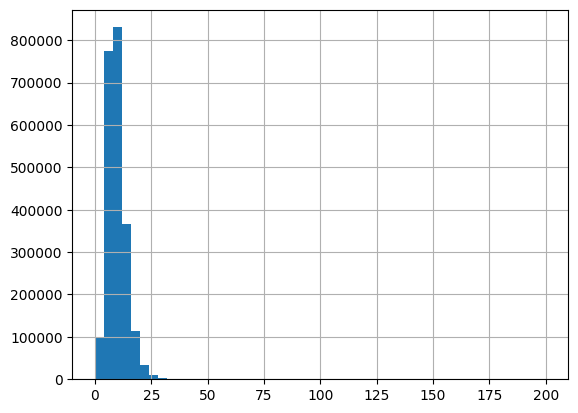

In [8]:
# load final deduped parquet and show sample
df_final = pd.read_parquet("../data/normalized/recipes_data_clean_spell_dedup.parquet")
print("Sample of final deduped dataset:")

# #display the full NER/ NER_clean columns with no truncation
# with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
#     display(df_final[[NER_COL, "NER_clean"]].head(100))

bad = df_final[df_final["NER_clean"].apply(lambda lst: any(len(x.split())==1 for x in lst))].sample(10)
display(bad[["NER", "NER_clean"]])

lens = [len(x) for x in df_final["NER_clean"]]
pd.Series(lens).hist(bins=50)
normalizer = StatsNormalizer(
    max_ngram=4,
    min_unigram=MIN_UNIGRAM,
    min_bigram=max(30, MIN_BIGRAM//1),      # a bit lower
    min_trigram=max(20, MIN_TRIGRAM//1),
    pmi_bigram=max(2.6, PMI_BIGRAM-0.4),
    pmi_trigram=max(1.8, PMI_TRIGRAM-0.2),
    min_child_share=0.06,                   # was 0.12
    max_right_entropy=1.3,                  # was 1.0

    # fallbacks
    pmi_bigram_fallback=2.2,
    min_bigram_fallback=15,
    pmi_trigram_fallback=1.8,
    min_trigram_fallback=10,
    min_child_share_fallback=0.05,
    max_right_entropy_fallback=1.5,

    snap_score_cutoff=88,                   # was 92
    snap_near_perfect=94                    # was 96
)

canon_vocab = {" ".join(t) for t in normalizer.canon}
unmatched = [tok for lst in df_final["NER_clean"] for tok in lst if tok not in canon_vocab]
print(f"{len(set(unmatched))} unmatched out of {len(canon_vocab)} canon terms")



In [9]:
import pandas as pd

canon_vocab = {" ".join(t) for t in normalizer.canon}

emitted = (
    pd.Series(df_final["NER_clean"])
      .explode()
      .dropna().astype(str).str.strip()
)

unmatched = emitted[~emitted.isin(canon_vocab)]
coverage = 1.0 - unmatched.size / emitted.size
print(f"Canon coverage: {coverage:.2%}  ({unmatched.nunique()} unique unmatched / {emitted.nunique()} unique total)")

print("\nTop 50 unmatched tokens (by frequency):")
print(unmatched.value_counts().head(50))


Canon coverage: 0.00%  (35687 unique unmatched / 35687 unique total)

Top 50 unmatched tokens (by frequency):
NER_clean
salt               1007465
sugar               658358
onion               535339
butter              521740
flour               521089
garlic              425517
eggs                419762
milk                404308
pepper              390848
water               343099
vanilla             293044
olive oil           217254
cheese              182753
brown sugar         182103
red                 179897
cream               179351
egg                 178692
tomatoes            176445
baking powder       160918
white               156705
lemon juice         153945
cinnamon            131401
chicken             125445
celery              125073
parsley             125054
sour cream          122449
oil                 121408
baking soda         120483
onions              119754
green               116072
cheddar cheese      113802
margarine           113549
vegetable oil   